In [ ]:
from OutsideWorld.Finance import Stock

a = Stock.Stock()

b = a.get_historical_cash_flow_statement("USB")
import matplotlib.pyplot as plt
df = b[b["calendarYear"] > "2017"].sort_index()
x = df.index
y = df["freeCashFlow"] 
y_sma = df["freeCashFlow"].rolling(6).mean() 

plt.plot(x,y,'bo-', linewidth=2, markersize=4, label = "FCF")
plt.plot(x,y_sma,'g-', linewidth=2, markersize=4, label = "6q FCF sma")
plt.xticks(rotation=90)
plt.show()

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TGOPY.csv' for TGOPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ACOPY.csv' for ACOPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AACAY.csv' for AACAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/ABBNY.csv' for ABBNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ABZPY.csv' for ABZPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SLFPY.csv' for SLFPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AGRPY.csv' for AGRPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ACLLY.csv' for ACLLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ACCYY.csv' for ACCYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ADLDY.csv' for

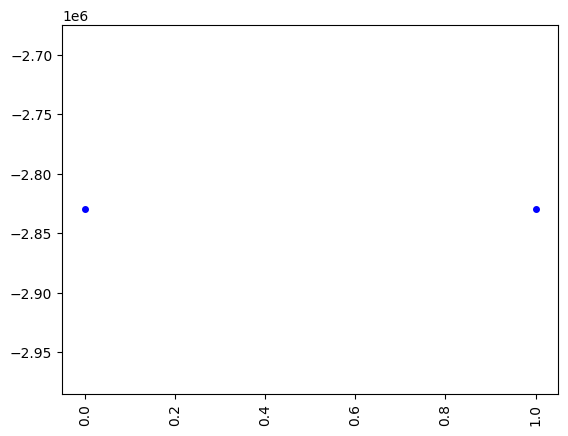

ASEKY 724424242.424241 7.354538801088672 1.049352 30.87
[5000000, 26979000000, 29000000, 18867000000, 0, 26962000000, 120000000, 18966000000, 16000000, 26990000000]


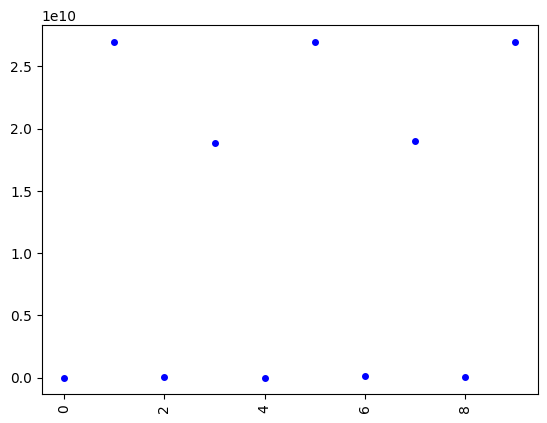

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/AKRBY.csv' for AKRBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/AHLA.csv' for AHLA
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ALBBY.csv' for ALBBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ALSMY.csv' for ALSMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AWCMY.csv' for AWCMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CTXAY.csv' for CTXAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AELIY.csv' for AELIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ANPCY.csv' for ANPCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ANGPY.csv' for ANGPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NGLOY.csv' for NGLO

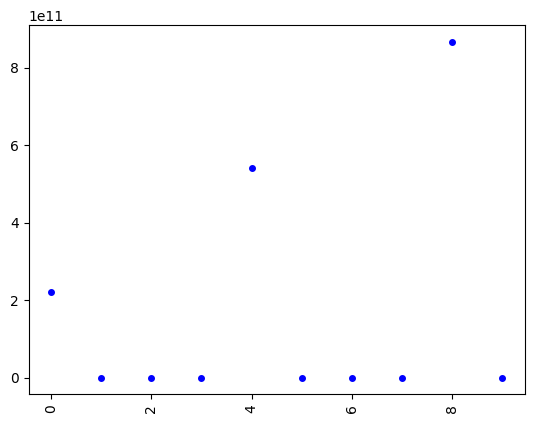

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BNDSY.csv' for BNDSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/ITCL.csv' for ITCL
BMA 569918345.2380953 5.623784479493831 1.053561 23.7
[-0.0, -0.0, -0.0, -0.0, -0.0, 5594102000.0, 6218167000.0, -0.0]


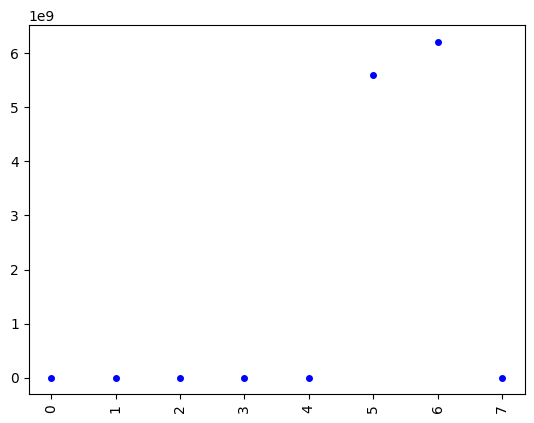

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/BRASIL.csv' for BRASIL
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/PERSERO.csv' for PERSERO
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BKEAY.csv' for BKEAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BKRIY.csv' for BKRIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BKQNY.csv' for BKQNY
BKRKY 2968819000000.0005 0.13092198734046456 35.440953 18.56
[0, 0, 0, 0, 0, 0, 650614000000, 949616000000, 43494766000000]


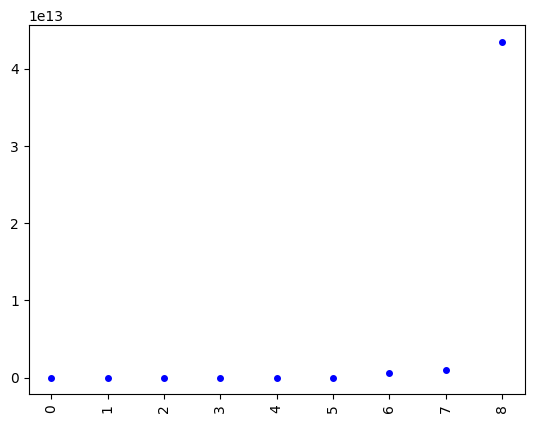

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BRRAY.csv' for BRRAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BTDPY.csv' for BTDPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BRRLY.csv' for BRRLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BCHEY.csv' for BCHEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BJCHY.csv' for BJCHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BJWTY.csv' for BJWTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BHBSY.csv' for BHBSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BKGFY.csv' for BKGFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BDDDY.csv' for BDDDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BDVSY.csv' 

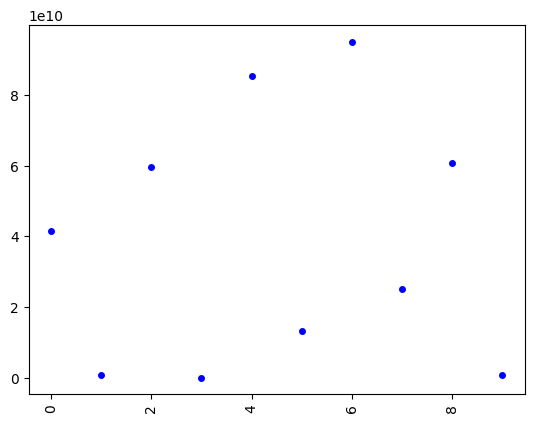

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BTVCY.csv' for BTVCY
BRTHY 347648484.84848464 9.695093444623087 0.8769899999999999 34.01
[0, 8589000000, 0, 7808000000, 0, 14220000000, 1583000000, 8710000000, 0, 8710000000]


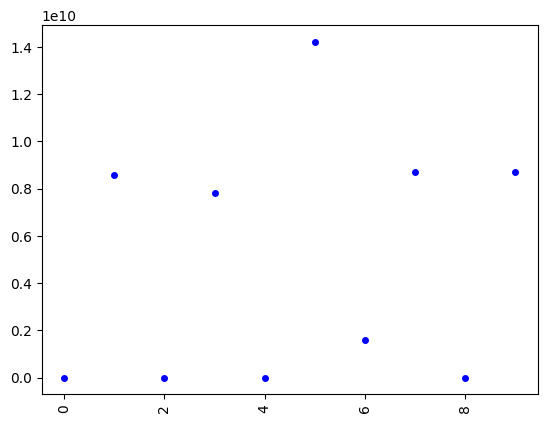

TBNGY 133333.33333333337 0.06887645286267757 17.4225 4.8
[0, 0, 0, 2000000, 0, 0, 2000000, 2000000, 0]


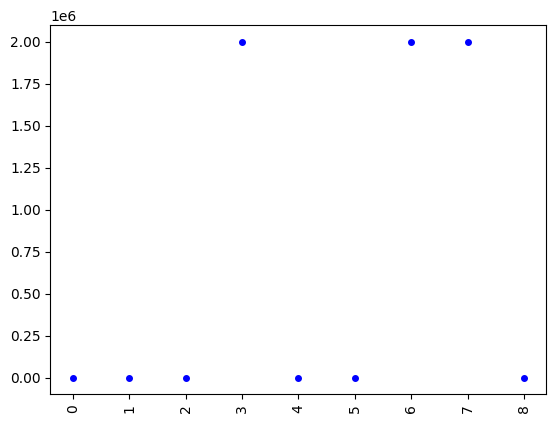

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BZLFY.csv' for BZLFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BURBY.csv' for BURBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BVVBY.csv' for BVVBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BZZUY.csv' for BZZUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/INTERNATIONAL.csv' for INTERNATIONAL
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CAIXY.csv' for CAIXY
CLBEY 408951515.1515148 13.464590646323522 0.08631899999999999 4.649
[1000000, 6540000000, 144000000, 6756000000, 5252000000, 6571000000, 150000000, 4462000000, 7539000000, 6378000000]


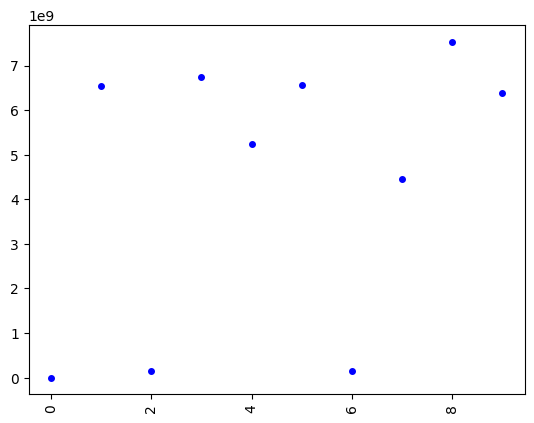

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/CAJPY.csv' for CAJPY
CCOEY 755878787.8787876 17.55281696015911 0.299667 21.04
[-2496000000, 4911000000, 5000000, 3844000000, 5000000, 5978000000, 13652000000, 4902000000, 5000000, 8524000000]


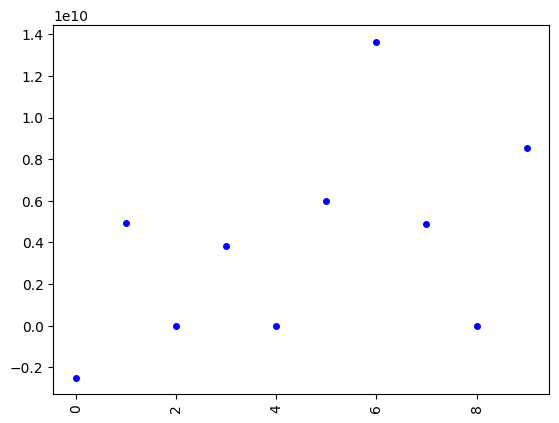

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CGEMY.csv' for CGEMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CKHGY.csv' for CKHGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CRNCY.csv' for CRNCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CRRFY.csv' for CRRFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CSXXY.csv' for CSXXY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CGUSY.csv' for CGUSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CEBUY.csv' for CEBUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CLLNY.csv' for CLLNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/CYADY.csv' for CYADY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CMTOY.csv' for

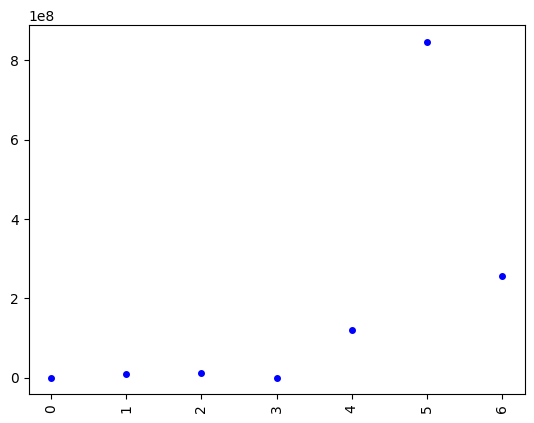

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CPYYY.csv' for CPYYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CRPHY.csv' for CRPHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CFIGY.csv' for CFIGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CMGMY.csv' for CMGMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CCOZY.csv' for CCOZY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CDGXY.csv' for CDGXY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CHFFY.csv' for CHFFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CFEIY.csv' for CFEIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CHFHY.csv' for CHFHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CGHLY.csv' 

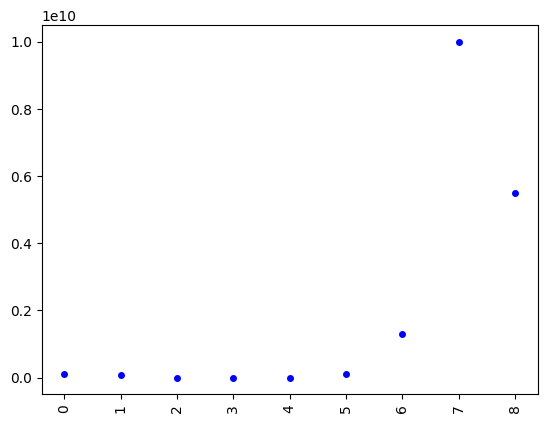

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/COIHY.csv' for COIHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CSLLY.csv' for CSLLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/CSPCY.csv' for CSPCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DSFGY.csv' for DSFGY
DIFTY 674478787.8787875 14.277387404183463 0.466647 26.65
[2483000000, 16804000000, 732000000, 15613000000, -246000000, -519000000, 287000000, 17035000000, 8604000000, 17308000000]


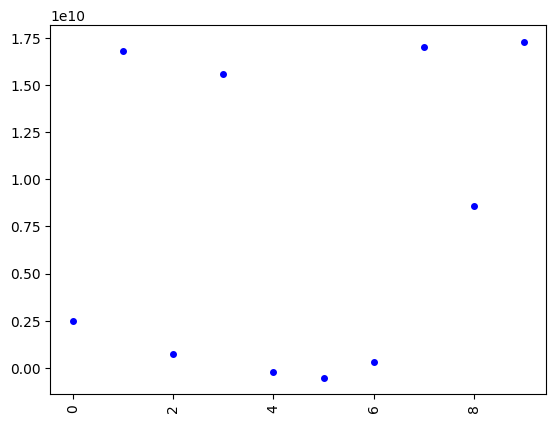

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DSEEY.csv' for DSEEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DNKLY.csv' for DNKLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DANOY.csv' for DANOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DRKTY.csv' for DRKTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DTTLY.csv' for DTTLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DVCMY.csv' for DVCMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DLUEY.csv' for DLUEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DPHAY.csv' for DPHAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WILYY.csv' for WILYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DFIHY.csv' 

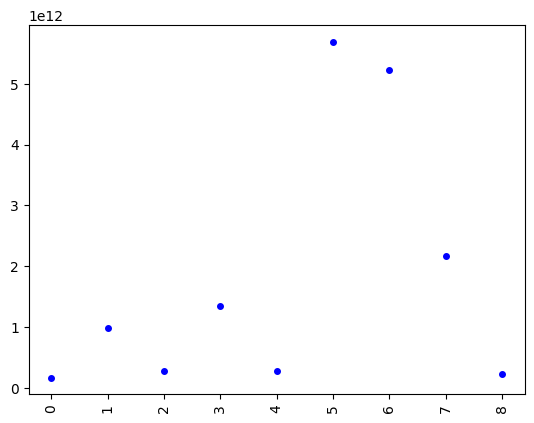

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/EDNMY.csv' for EDNMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/EFGSY.csv' for EFGSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/ESAIY.csv' for ESAIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/EDESY.csv' for EDESY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ELMTY.csv' for ELMTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ELMUY.csv' for ELMUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/AKO.A.csv' for AKO.A
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/AKO.B.csv' for AKO.B
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/EGRAY.csv' for EGRAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ENGIY.csv' for ENGIY

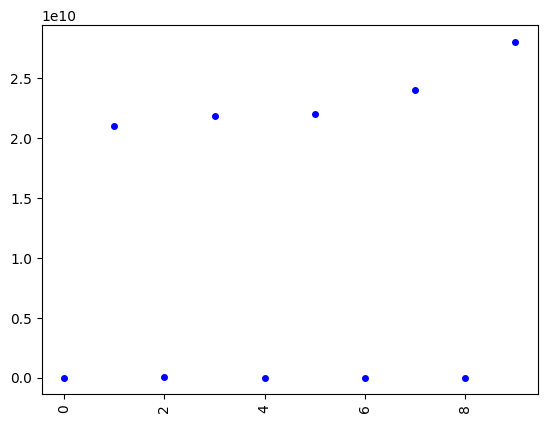

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/YMM.csv' for YMM
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GXYYY.csv' for GXYYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GBERY.csv' for GBERY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GELYY.csv' for GELYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GNTA.csv' for GNTA
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GVDNY.csv' for GVDNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GLAPY.csv' for GLAPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GLNCY.csv' for GLNCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GLYYY.csv' for GLYYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GBXXY.csv' for GB

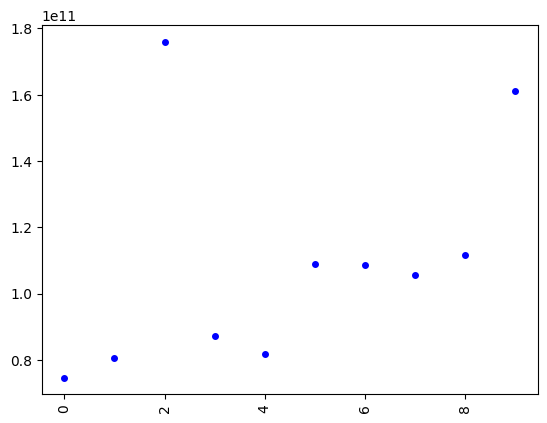

SUPV 58943616.66666668 16.377989866855188 0.042435 2.78
[0, 427356000, 39671000, 47684000, 0, 343789000, 75553000, 1035984000, 335716000]


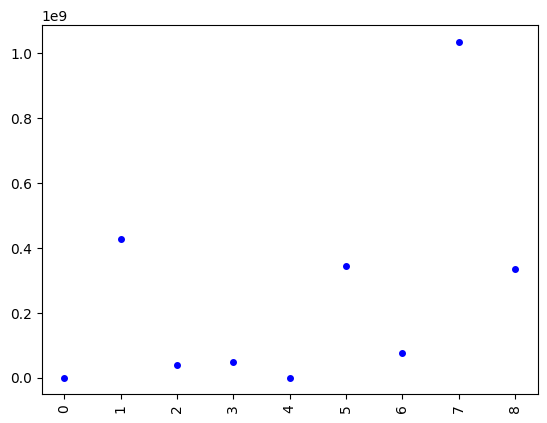

TV 105459928.57142852 5.698005698005697 0.201825 4.6
[50500000, 1053392000, 63000000, 324654000, 596242000, 1103392000, 823712000]


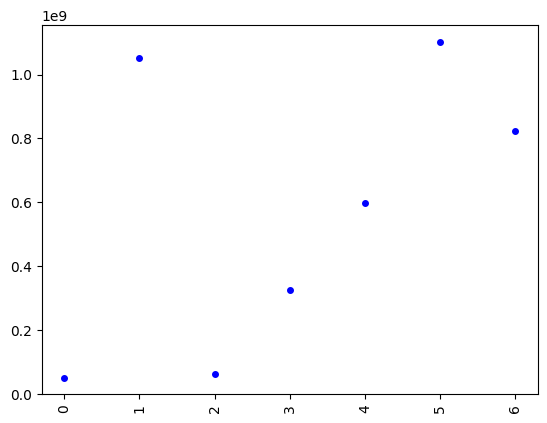

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GGDVY.csv' for GGDVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/GNZUY.csv' for GNZUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/GULRY.csv' for GULRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HLN.csv' for HLN
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HLFDY.csv' for HLFDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HALMY.csv' for HALMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HPHTY.csv' for HPHTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HNLGY.csv' for HNLGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HLPPY.csv' for HLPPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HSNGY.csv' for HSN

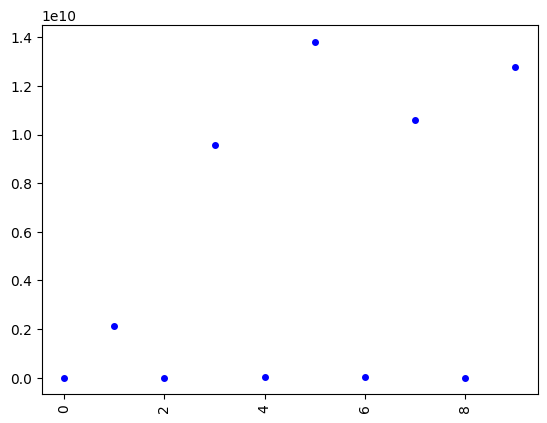

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HKTTY.csv' for HKTTY
HMC 1085521212.121211 5.211661949541982 1.511514 31.51
[44909000000, 93272000000, 0, 95130000000, 0, 111256000000, 0, 102219000000, 0, 99915000000]


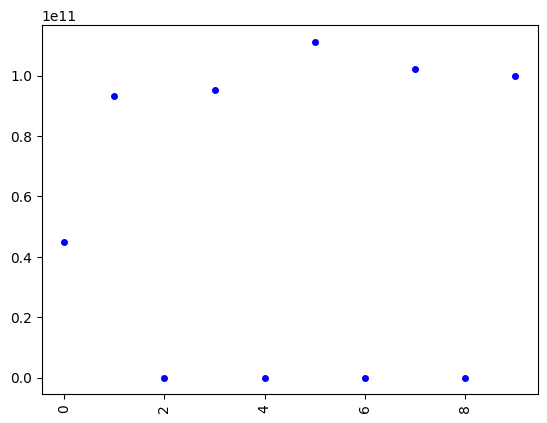

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HOKCY.csv' for HOKCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HKTVY.csv' for HKTVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HNGKY.csv' for HNGKY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HWDJY.csv' for HWDJY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HPIFY.csv' for HPIFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HNTIY.csv' for HNTIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HUTCY.csv' for HUTCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HYSNY.csv' for HYSNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ICABY.csv' for ICABY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/IGGHY.csv' 

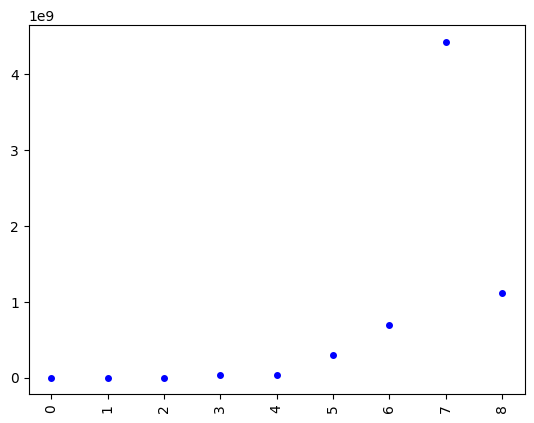

ITOCY 4628599999.999998 9.334290747208119 2.022114 75.5
[3510000000, 67375000000, 12000000, 75794000000, 60009000000, 92715000000, 0, 95657000000, 0, 109265000000]


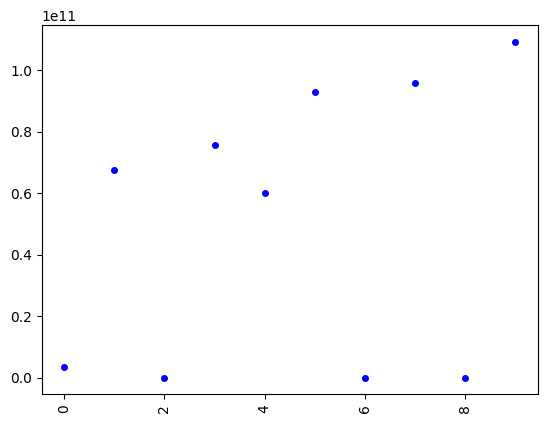

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ITVPY.csv' for ITVPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JSAIY.csv' for JSAIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JDWPY.csv' for JDWPY
JAPSY 1500612121.21212 14.237386801104941 0.182091 10.37
[-17396000000, 3000000, 81000000, 78000000, 1000000, 1000000, 0, 1000000, 0, 10188000000]


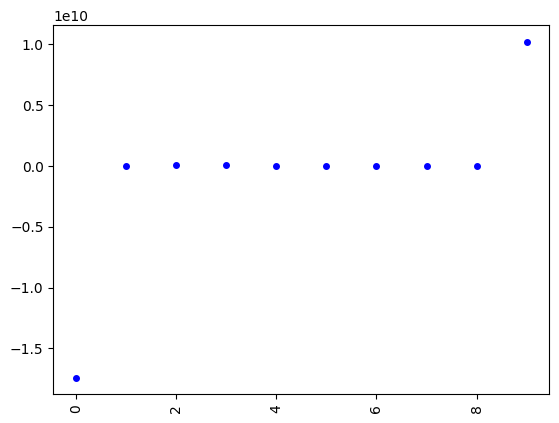

JPXGY 289109090.90908986 18.307307613798734 0.11757599999999999 8.61
[0, 33303000000, 9562000000, 13743000000, 0, 26289000000, 0, 13743000000, 10031000000, 22738000000]


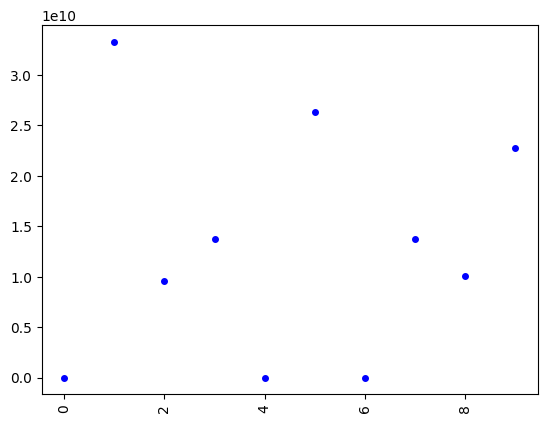

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JPPTY.csv' for JPPTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JPPHY.csv' for JPPHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JMHLY.csv' for JMHLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JDSPY.csv' for JDSPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WDGJY.csv' for WDGJY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JMPLY.csv' for JMPLY
JTEKY 324290909.09090894 7.385007236978139 0.9043829999999999 26.7155
[0, 2744000000, 0, 2744000000, 0, 3430000000, 0, 3773000000, 0, 6517000000]


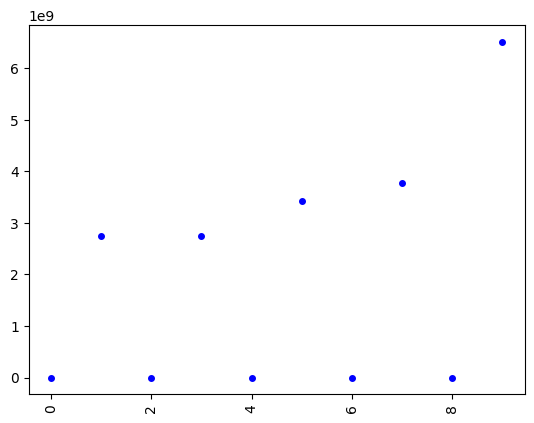

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JBAXY.csv' for JBAXY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JUMSY.csv' for JUMSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/JTKWY.csv' for JTKWY
JVCZY 275121212.121212 6.7395617667356795 0.602784 16.25
[0, 819000000, 0, 0, 0, 980000000, 0, 0, 0, 5572000000]


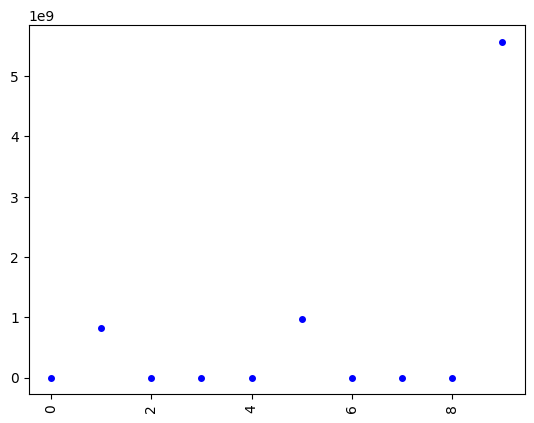

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KPTCY.csv' for KPTCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KRNGY.csv' for KRNGY
KWHIY 691416666.6666669 16.62227384695492 0.14979900000000002 9.96
[25000000, 2000000, 3102000000, 255000000, 3082000000, 269000000, 4631000000, 401000000, 9329000000]


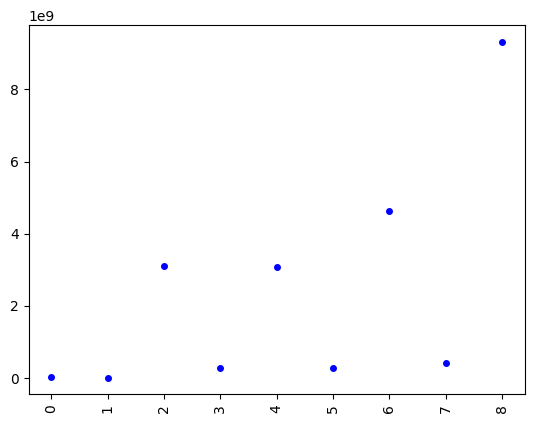

KB 12118945454.545448 0.3814135040530582 26.0544 39.75
[0, 0, 292226000000, 0, 0, 0, 194817000000, 194818000000, 271745000000, 0]


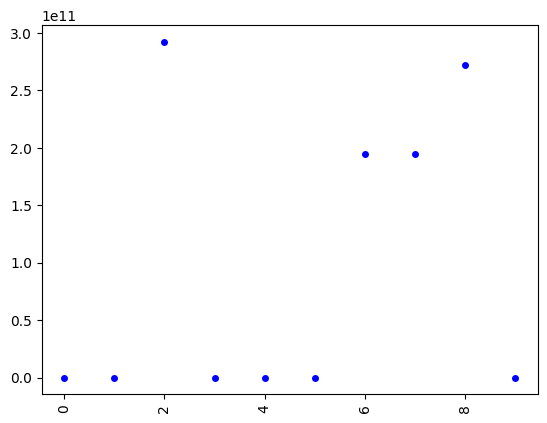

KDDIY 665848484.8484837 12.916609239881401 0.28296899999999997 14.62
[77988000000, 192016000000, 140960000000, 82485000000, 54962000000, 200577000000, 49628000000, 244077000000, 34836000000, 149932000000]


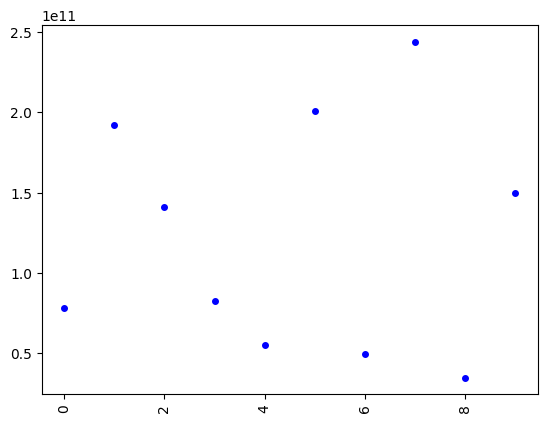

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PPRUY.csv' for PPRUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KRYAY.csv' for KRYAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KRYPY.csv' for KRYPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KYYWY.csv' for KYYWY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KGBLY.csv' for KGBLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KGDEY.csv' for KGDEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KGFHY.csv' for KGFHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KGSPY.csv' for KGSPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KLMR.csv' for KLMR
KOTMY 693848484.8484845 13.31762251417631 0.314433 16.75
[236000000, 4494000000, 325000000, 3

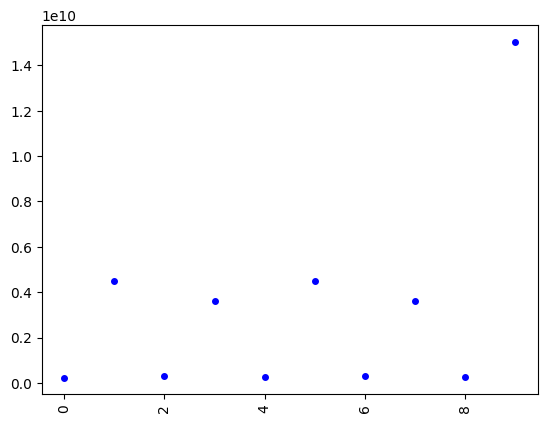

KMTUY 3853539393.9393916 8.88167002694724 0.769281 27.33
[0, 34986000000, 0, 37829000000, 0, 52963000000, 0, 60542000000, 0, 70950000000]


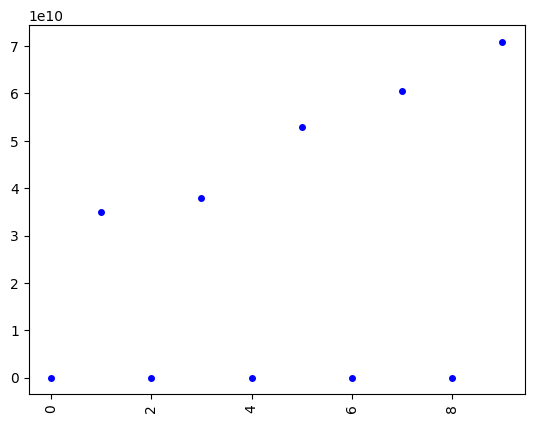

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VOPKY.csv' for VOPKY
KT 71549183333.33336 0.773405359442798 3.99855 12.37
[-537162000000.0, -260928000000.0, -941000000.0, -394937000000.0, -0.0, 476800000000.0, -0.0, -0.0, 121975000000.0]


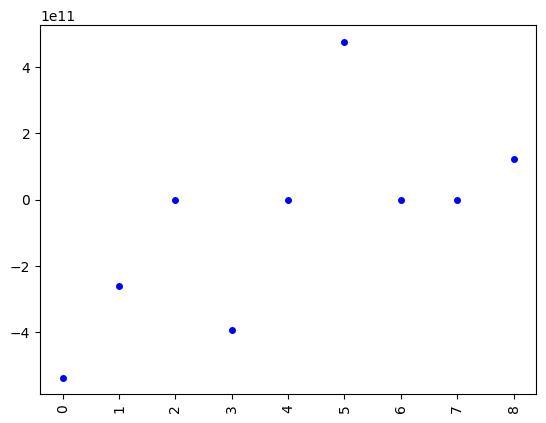

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KIROY.csv' for KIROY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/KLYCY.csv' for KLYCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LDSCY.csv' for LDSCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LDGYY.csv' for LDGYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LTOUF.csv' for LTOUF
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LMPMY.csv' for LMPMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LGGNY.csv' for LGGNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LLESY.csv' for LLESY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LNNGY.csv' for LNNGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LTGHY.csv' 

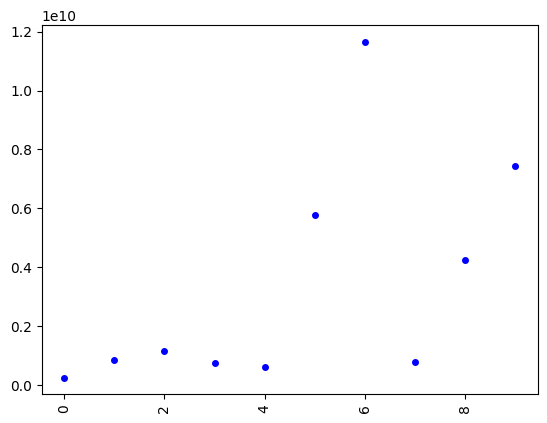

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PPLFY.csv' for PPLFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LGFRY.csv' for LGFRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LKHLY.csv' for LKHLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LZAGY.csv' for LZAGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LRLCY.csv' for LRLCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LOTBY.csv' for LOTBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LVMUY.csv' for LVMUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/LYSDY.csv' for LYSDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MQBKY.csv' for MQBKY
MYTAY 2045212121.2121203 1.9507097986842756 0.80868 6.31
[0, 10215000000, 3648000000, 0, 0,

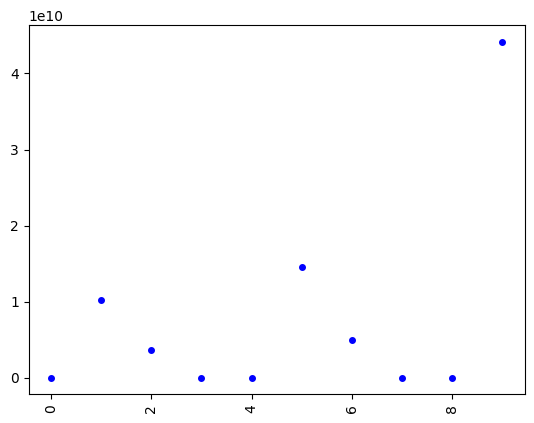

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MAHMF.csv' for MAHMF
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MPFRY.csv' for MPFRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MAKSY.csv' for MAKSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MRTPY.csv' for MRTPY
MZDAY 1317199999.9999993 6.177560746014003 0.20396399999999998 5.04
[0, 0, 0, 0, 0, 12597000000, 0, 12600000000, 0, 15749000000]


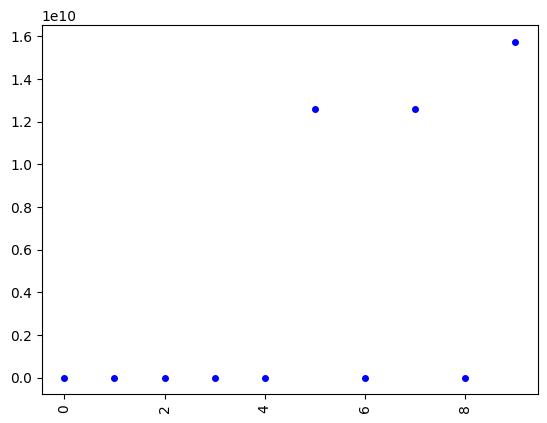

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MDIBY.csv' for MDIBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MDEVY.csv' for MDEVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MCARY.csv' for MCARY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MCHVY.csv' for MCHVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/MINBY.csv' for MINBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MALRY.csv' for MALRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MNSO.csv' for MNSO
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MNTHY.csv' for MNTHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MITFY.csv' for MITFY
MTLHY 170890909.09090835 7.161581362444822 1.031895 29.56
[7000000, 55128000000, 10000000, -3141

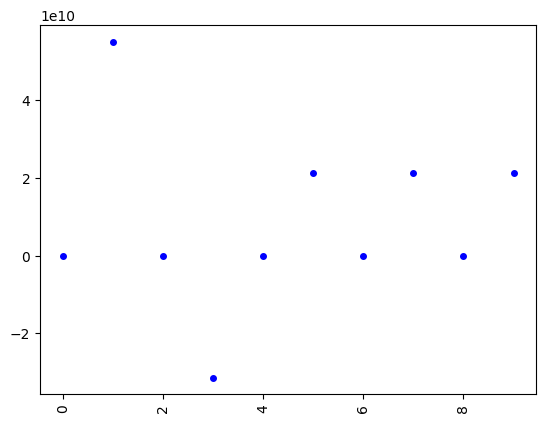

MITSY 5394866666.666666 8.082128796804506 22.96734 742.5
[0, 75083000000, 0, 73123000000, 0, 96058000000, 0, 102024000000, 0, 114325000000]


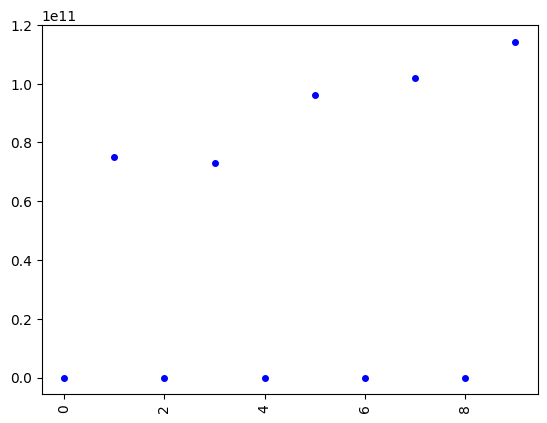

MITUY 860866666.6666662 19.652530056810676 0.174087 13.685
[17000000, 9806000000, 3505000000, 17242000000, 5000000, 12563000000, 3000000, 16588000000, 11695000000, 11413000000]


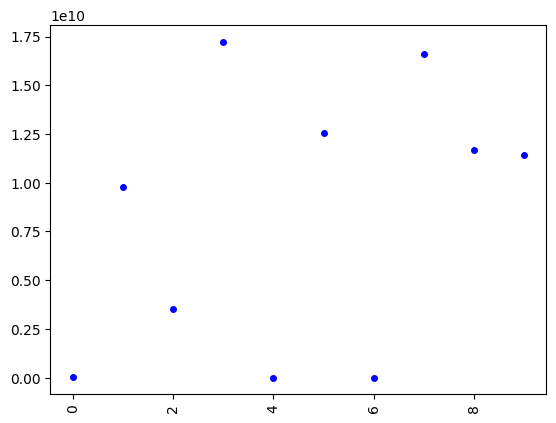

MGYOY 1562187878.7878783 1.2206983756443928 0.771075 3.765
[0, 0, 63207000000, 6000000, 2000000, 2000000, 191199000000, 33000000, 1000000, 5000000]


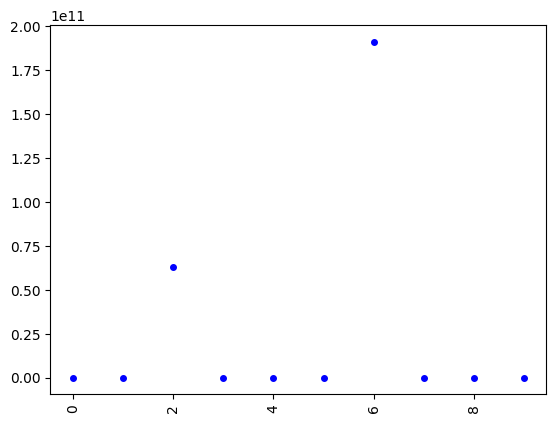

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MONDY.csv' for MONDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MOHCY.csv' for MOHCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MTGRY.csv' for MTGRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MRPLY.csv' for MRPLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MTNOY.csv' for MTNOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MTCPY.csv' for MTCPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MCHOY.csv' for MCHOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NGCRY.csv' for NGCRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/MJWNY.csv' for MJWNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NPKLY.csv' 

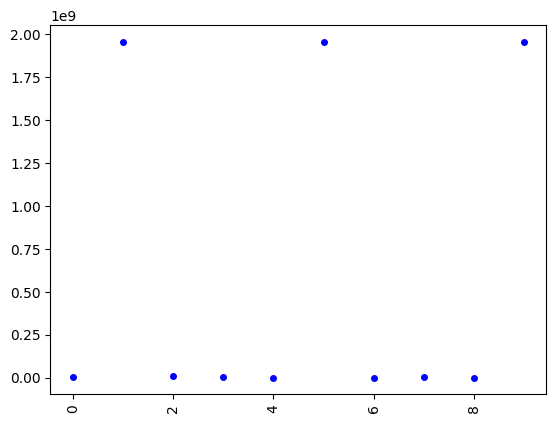

NPPNY 44566666.66666676 11.751936531734135 0.22411199999999998 10.535
[3161000000, 204000000, 3241000000, 195000000, 3753000000, 218000000, 3628000000, 211000000, 3625000000]


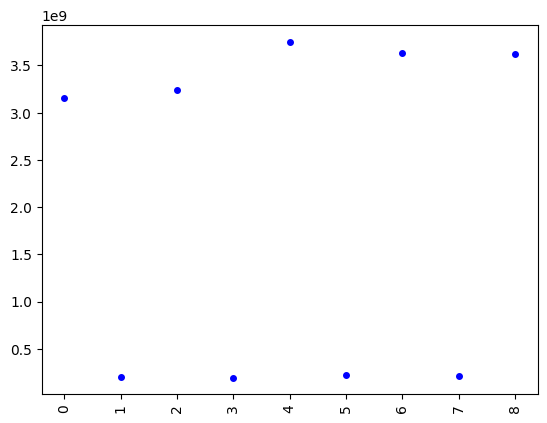

NPSCY 8702533333.33333 4.34172054244371 0.44222100000000003 7.68
[15000000, 14145000000, 20000000, -234151000000, 13000000, 82984000000, 12000000, 82989000000, 23000000, 37178000000]


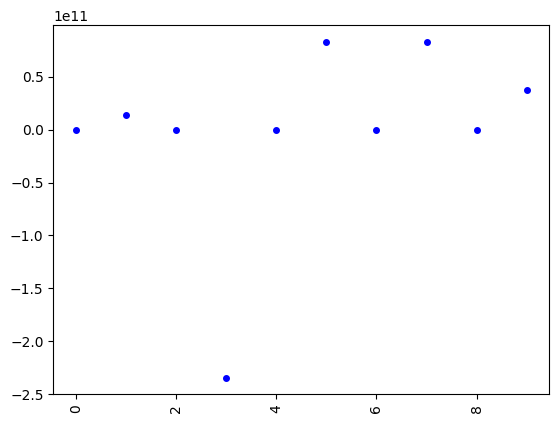

NTTYY 5247345454.545472 9.267475105984422 0.760725 28.2
[455934000000, -316327000000, 85508000000, 365683000000, 149000000, 212633000000, 360291000000, 228900000000, 0, 204629000000]


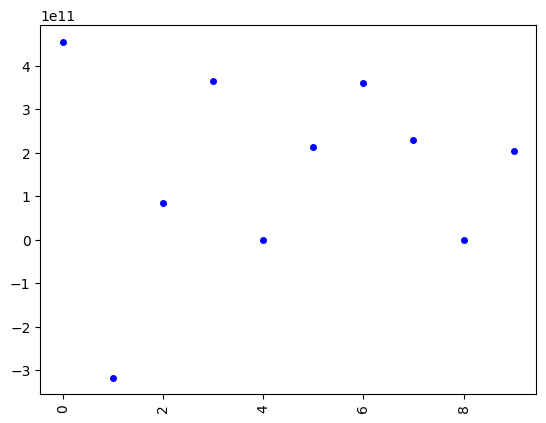

NNCHY 579442424.2424235 17.85062846151295 0.60306 43.06
[3001000000, 15341000000, 1000000, 7129000000, 5000000000, 15208000000, 1000000, 9877000000, 4000000000, 18200000000]


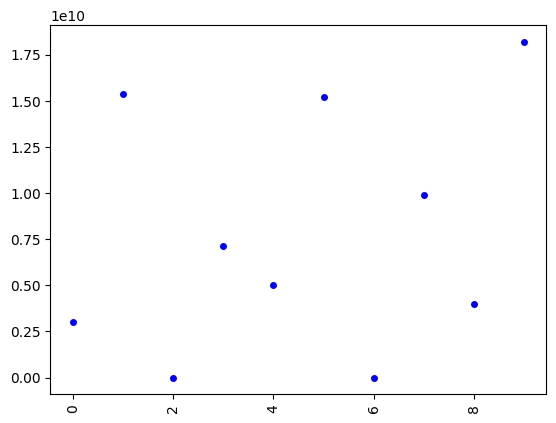

NSANY 2422927272.727272 5.617085627256925 0.37163399999999996 8.35
[0, 0, 0, 0, 1000000, 19573000000, 0, 5529000000, 0, 39174000000]


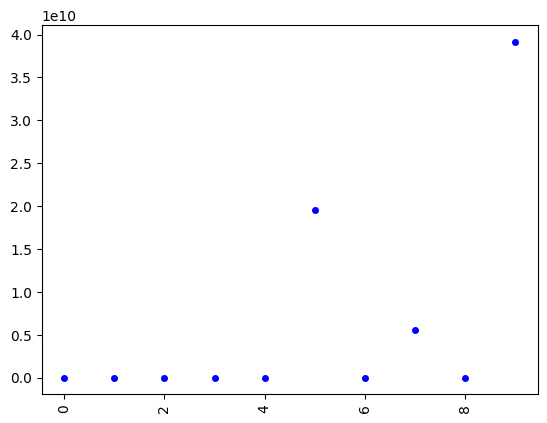

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NSHBY.csv' for NSHBY
NGKSY 957696969.6969692 6.809538493164766 0.408618 11.13
[14000000, 7078000000, 545000000, 9753000000, 27000000, 10928000000, 71000000, 16870000000, 38000000, 15994000000]


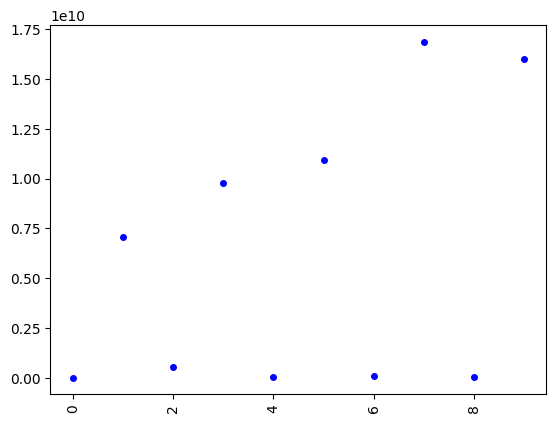

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/NRKBY.csv' for NRKBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NMHLY.csv' for NMHLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NSTYY.csv' for NSTYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/NYRSY.csv' for NYRSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/OERLY.csv' for OERLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OCDDY.csv' for OCDDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/OLYMY.csv' for OLYMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OGBLY.csv' for OGBLY
OPHLY 292006060.60606074 10.6426989083727 0.149868 6.38
[692000000, 12650000000, 1057000000, 28612000000, 15354000000, 12653000000, 998000000, 15150000000, 942000000, 16827000000]


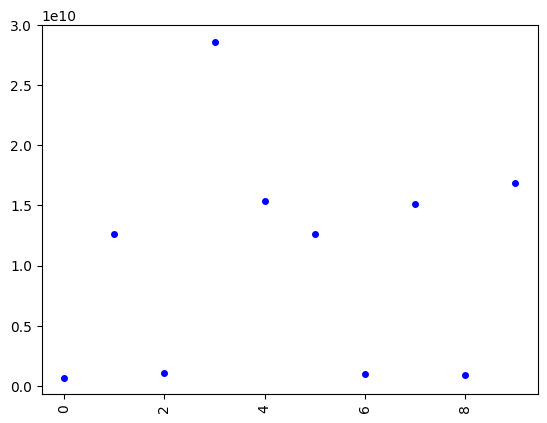

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OCLDY.csv' for OCLDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OROVY.csv' for OROVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OGFGY.csv' for OGFGY
IX 23218216666.66667 12.207326817378389 1.8585150000000001 90.75
[5280000000, -308026000000, 20330000000, -210614000000, 0, 66047000000, 22808000000, 69506000000, 0]


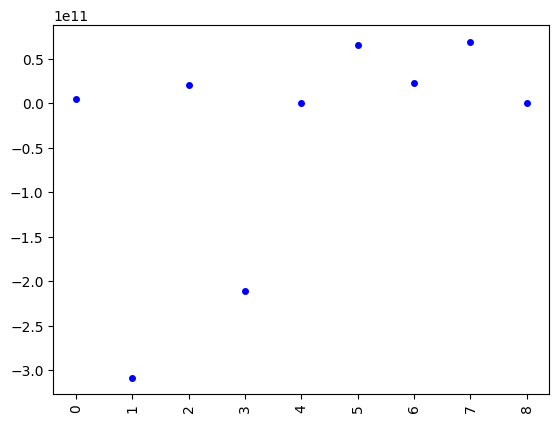

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/OSSUY.csv' for OSSUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/income/PCFBY.csv' for PCFBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PAFRY.csv' for PAFRY
PCRFY 825521212.1212102 4.8404584882280055 0.5939519999999999 11.5
[17000000, 40561000000, 13000000, 35018000000, 9000000, 35036000000, 7000000, 35018000000, 8000000, 35024000000]


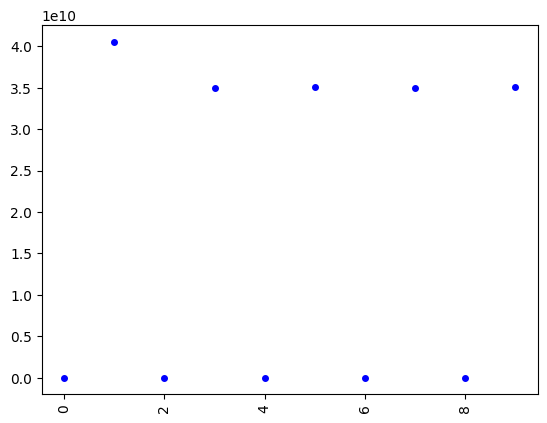

PKCOY 9921212.121212116 18.40999048817158 0.195546 14.4
[-59000000, 1000000, 1000000, 0, 2000000, 4000000, 368000000, 1000000, 1000000, 0]


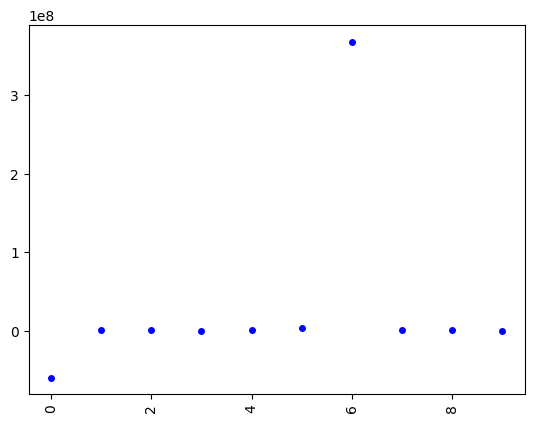

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/PTNRY.csv' for PTNRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PCCWY.csv' for PCCWY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PEGRY.csv' for PEGRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/PIXNY.csv' for PIXNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ILPMY.csv' for ILPMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PRNDY.csv' for PRNDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PSMMY.csv' for PSMMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/POFCY.csv' for POFCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/PBR.A.csv' for PBR.A
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PGPKY.csv' for PGPKY

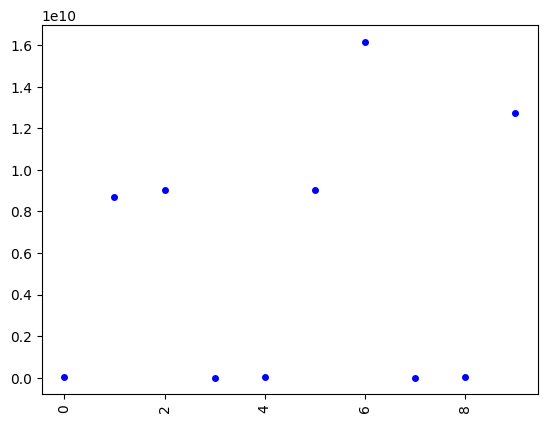

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AUCOY.csv' for AUCOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/DRPRY.csv' for DRPRY
PKX 50139599999.99996 1.5795694091974581 16.520325 104.38
[-1011843000000, 627676000000, 304786000000, 376891000000, 304000000, 759166000000, 307012000000, 151923000000, 384000000]


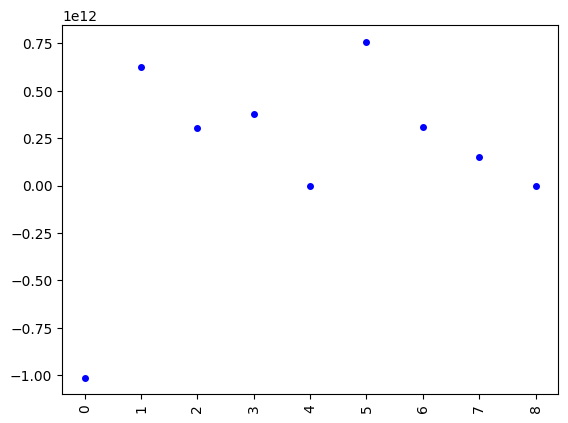

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PSTVY.csv' for PSTVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/HGKGY.csv' for HGKGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PRDSY.csv' for PRDSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PRRFY.csv' for PRRFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PUBGY.csv' for PUBGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PUYI.csv' for PUYI
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/PZCUY.csv' for PZCUY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/QABSY.csv' for QABSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/QBIEY.csv' for QBIEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/QNTQY.csv' fo

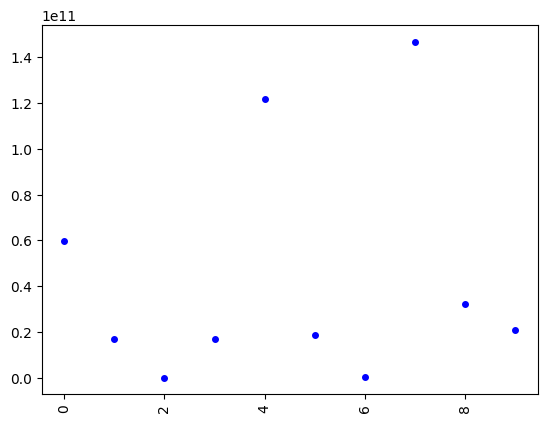

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RLFTY.csv' for RLFTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/REMYY.csv' for REMYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RNLSY.csv' for RNLSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RMGGY.csv' for RMGGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RTMVY.csv' for RTMVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RHHBY.csv' for RHHBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RYCEY.csv' for RYCEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RBSFY.csv' for RBSFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/RYHTY.csv' for RYHTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SAXJY.csv' 

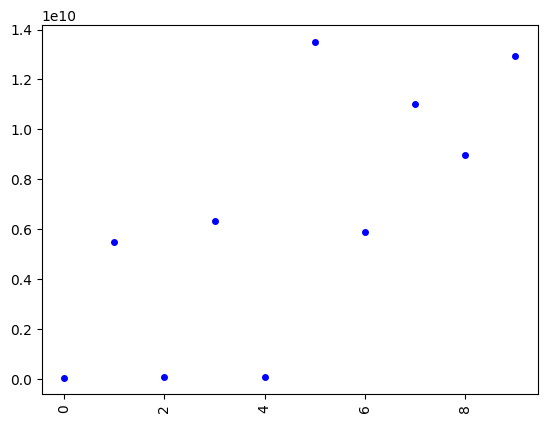

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SSLZY.csv' for SSLZY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SBFFY.csv' for SBFFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SBGSY.csv' for SBGSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SCTBY.csv' for SCTBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SKLTY.csv' for SKLTY
SEKEY 1253078787.8787875 9.328668998833917 0.210105 7.84
[1000000, 10725000000, 0, 10727000000, 0, 10726000000, 14999000000, 21719000000, 3911000000, 13592000000]


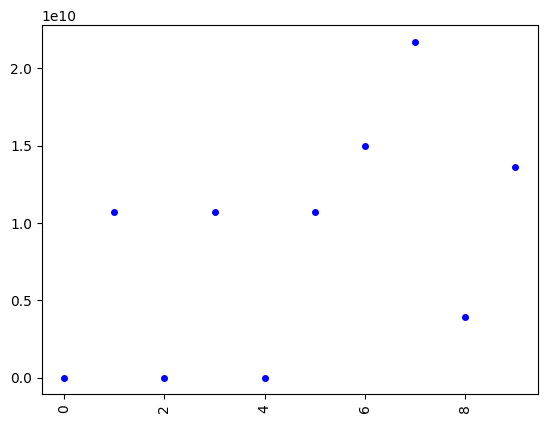

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SVNBY.csv' for SVNBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/STRNY.csv' for STRNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SGSOY.csv' for SGSOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/SHANY.csv' for SHANY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SHWGY.csv' for SHWGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/SHNXY.csv' for SHNXY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SIELY.csv' for SIELY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SGHIY.csv' for SGHIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SHALY.csv' for SHALY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SHGXY.csv' for SH

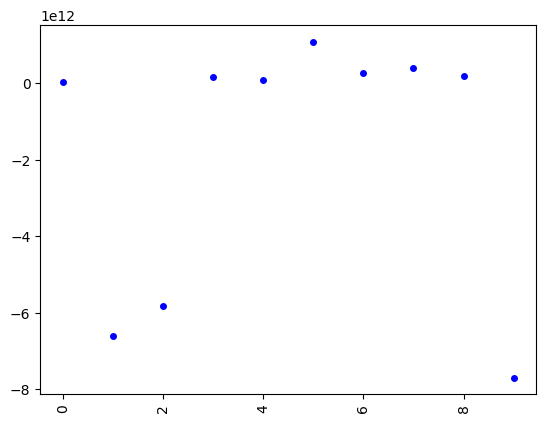

SGIOY 468527272.7272736 10.881589072720278 0.24950399999999998 10.86
[29682000000, 16578000000, 8000000, 16596000000, 24000000, 18090000000, 23365000000, 44266000000, 26000000, 22294000000]


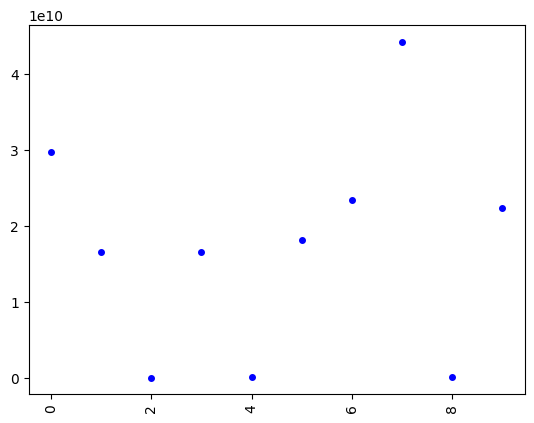

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SRGHY.csv' for SRGHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SOLLY.csv' for SOLLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SXYAY.csv' for SXYAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SMCYY.csv' for SMCYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SMSMY.csv' for SMSMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UILCY.csv' for UILCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SPSTY.csv' for SPSTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SBHMY.csv' for SBHMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SNLAY.csv' for SNLAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SIOLY.csv' 

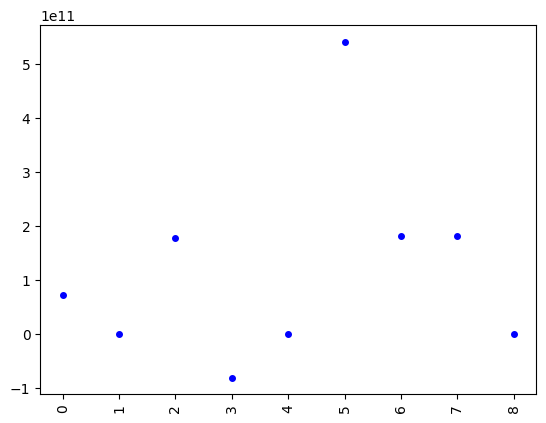

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SWDHY.csv' for SWDHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/EM.csv' for EM
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SMGZY.csv' for SMGZY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/SMSSY.csv' for SMSSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/BICEY.csv' for BICEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SCGLY.csv' for SCGLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SDXAY.csv' for SDXAY
SOBKY 39342945454.54542 13.12952752407275 0.213831 11.23
[-606955000000, 198519000000, 2962000000, 200918000000, 1210000000, 199455000000, 2852000000, 202138000000, 1114000000, 201211000000]


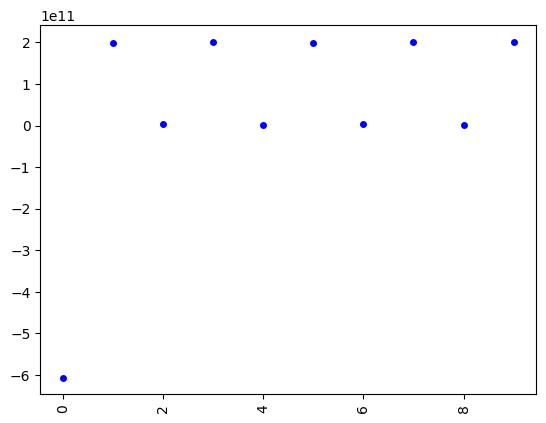

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/SOHGY.csv' for SOHGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SLOIY.csv' for SLOIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SKHHY.csv' for SKHHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SONVY.csv' for SONVY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SEPJY.csv' for SEPJY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SPXSY.csv' for SPXSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SPMYY.csv' for SPMYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SSEZY.csv' for SSEZY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/STBMY.csv' for STBMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SGBLY.csv' for

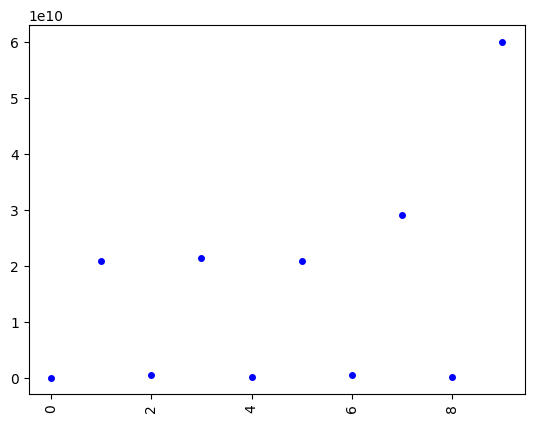

SSUMY 3663151515.1515126 6.882685551163812 0.72864 20.06
[0, 43740000000, 0, 56245000000, 0, 81250000000, 0, 71889000000, 0, 70960000000]


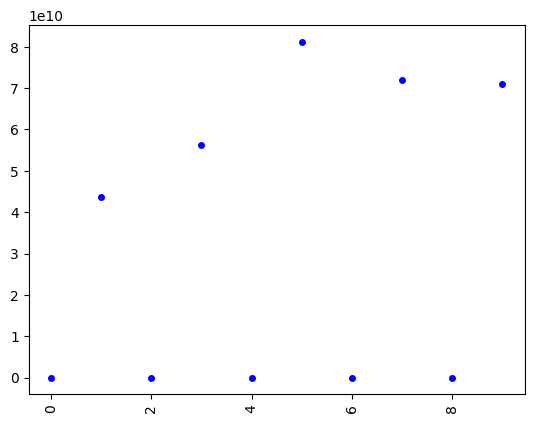

SMMYY 1067369696.9696963 14.888499546621174 0.130134 7.75
[0, 27203000000, 0, 31049000000, 0, 51657000000, 0, 24729000000, 0, 31598000000]


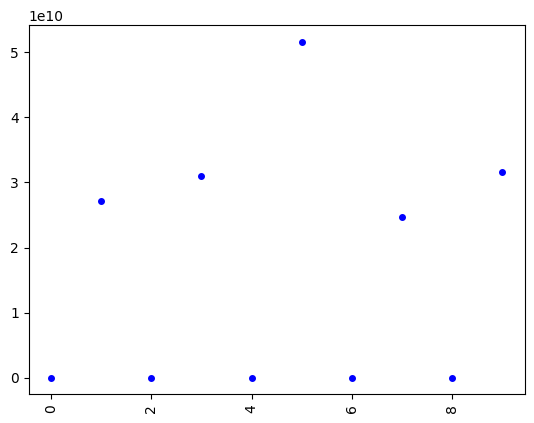

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SURRY.csv' for SURRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SHGKY.csv' for SHGKY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SUHJY.csv' for SUHJY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SNMCY.csv' for SNMCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SOTGY.csv' for SOTGY
STBFY 683509090.9090906 15.240171548416491 0.265581 16.19
[0, 0, 0, 0, 12050000000, 0, 12051000000, 0, 12668000000, 0]


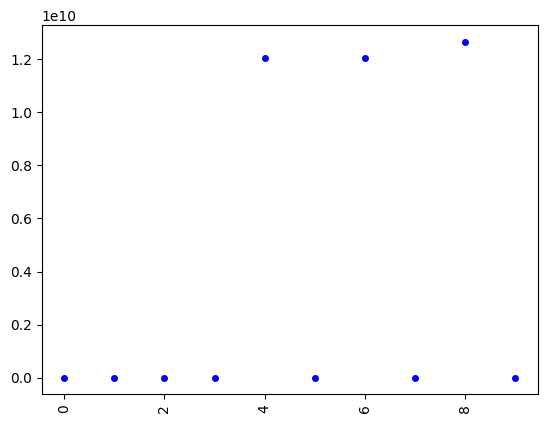

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SEPGY.csv' for SEPGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SWGAY.csv' for SWGAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/SWOBY.csv' for SWOBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SWRAY.csv' for SWRAY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SWRBY.csv' for SWRBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SZLMY.csv' for SZLMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SYT.csv' for SYT
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/SRHYY.csv' for SRHYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TACBY.csv' for TACBY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TATYY.csv' for TAT

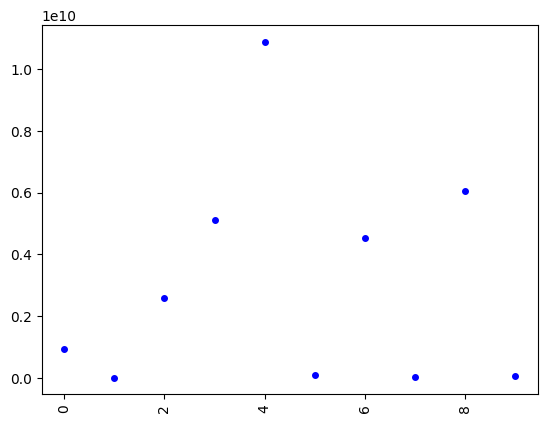

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TBLMY.csv' for TBLMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TSYHY.csv' for TSYHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TPRKY.csv' for TPRKY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TSRYY.csv' for TSRYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TKKYY.csv' for TKKYY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UBSFY.csv' for UBSFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UCBJY.csv' for UCBJY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UMICY.csv' for UMICY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UFGSY.csv' for UFGSY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/UUGRY.csv' 

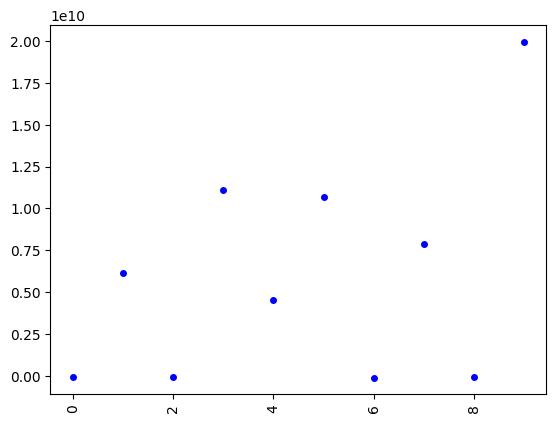

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VLEEY.csv' for VLEEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VTAGY.csv' for VTAGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VACNY.csv' for VACNY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VEOEY.csv' for VEOEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VCISY.csv' for VCISY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VDAHY.csv' for VDAHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VDMCY.csv' for VDMCY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/VTKLY.csv' for VTKLY
WACLY 327084848.4848484 14.590298161137664 1.691535 98.72
[-0.0, 1248000000.0, -0.0, 1839000000.0, 1500000000.0, 2891000000.0, 2288000000.0, 5312000000.0, 1787000000.0, 2322000000.0]


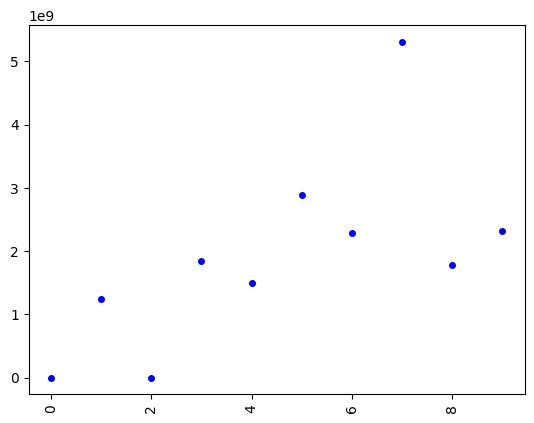

WACMY 77852490.90909082 11.380880121396054 0.090942 4.14
[425000, 2907007000, 169440000, 2006175000, 768000, 3283800000, 622628000, 437460000, 837202000, 2985070000]


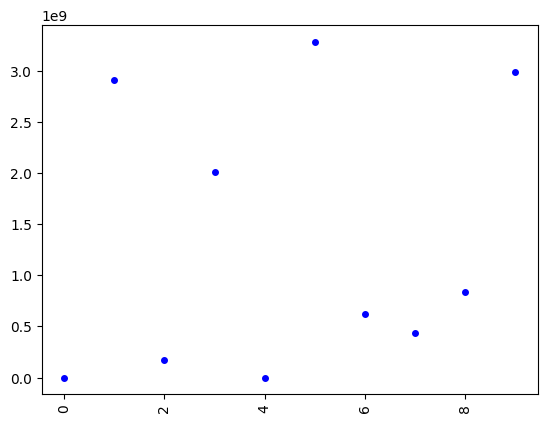

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WWNTY.csv' for WWNTY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WEICY.csv' for WEICY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WEIDY.csv' for WEIDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WEGRY.csv' for WEGRY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WFAFY.csv' for WFAFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WHGLY.csv' for WHGLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WARFY.csv' for WARFY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WTBDY.csv' for WTBDY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WIZEY.csv' for WIZEY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WZZZY.csv' 

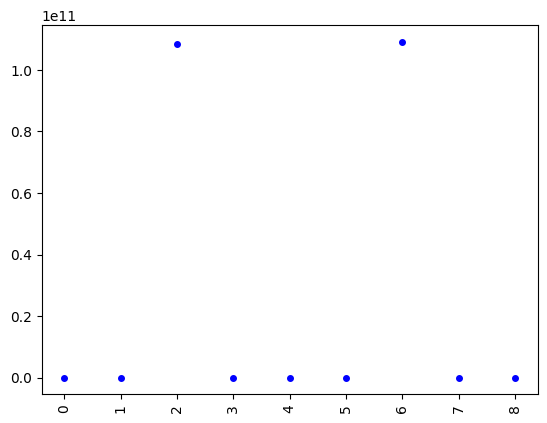

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WRDLY.csv' for WRDLY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WYGPY.csv' for WYGPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/WYNMY.csv' for WYNMY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/AIXI.csv' for AIXI
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/XYIGY.csv' for XYIGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/XISHY.csv' for XISHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/XTEPY.csv' for XTEPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/YAMHY.csv' for YAMHY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/TKLF.csv' for TKLF
YPF 118309090.90909086 2.8917014517380224 1.299408 15.03
[0, 0, 0, 0, 0, 0, 847000000, 33960000

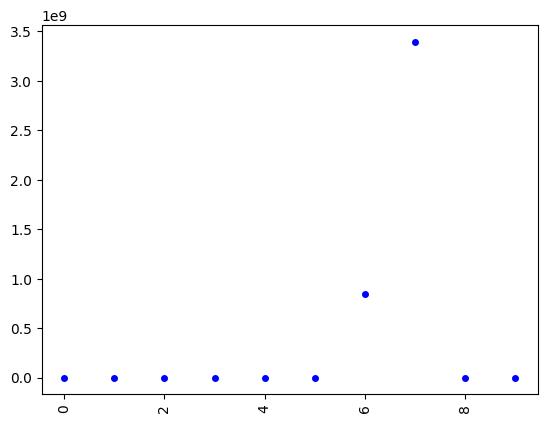

error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/YUEIY.csv' for YUEIY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/prices/ZMMPY.csv' for ZMMPY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ZH.csv' for ZH
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ZSHGY.csv' for ZSHGY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ZHUZY.csv' for ZHUZY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ZLIOY.csv' for ZLIOY
error: [Errno 2] No such file or directory: '/home/ubuntu/data/stocks/cash_flow/ZMTBY.csv' for ZMTBY


In [49]:
from pipelines.prices import get_symbols
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

symbols = get_symbols()

positive = []

for symbol in symbols[1400:]:
    DATA_PATH = "/home/ubuntu/data/stocks"

    # prices: all 
    cash_flow_cols = ["date", "symbol", "reportedCurrency" ,"freeCashFlow" ,"capitalExpenditure" ,"debtRepayment","commonStockIssued", "commonStockRepurchased", "dividendsPaid"]
    income_cols = ["date", "symbol", "revenue", "costOfRevenue", "ebitda" ,"netIncome" ,"eps"]
    balance_sheet_cols = ["date", "symbol",  "cashAndCashEquivalents" ,"totalAssets" ,"goodwillAndIntangibleAssets" ,"totalLiabilities" , "retainedEarnings"]
    # market_cap: all

    try: 
        data = {
            "prices": pd.read_csv(f"{DATA_PATH}/prices/{symbol}.csv"),
            "cash_flow": pd.read_csv(f"{DATA_PATH}/cash_flow/{symbol}.csv")[cash_flow_cols],
            "income": pd.read_csv(f"{DATA_PATH}/income/{symbol}.csv")[income_cols],
            #"balance_sheet": pd.read_csv(f"{DATA_PATH}/balance_sheet/{symbol}.csv")[balance_sheet_cols],
            #"market_cap": pd.read_csv(f"{DATA_PATH}/market_cap/{symbol}.csv")
        }
        for k,v in data.items():
            data[k]["date"] = pd.to_datetime(v["date"])
            data[k] = data[k].set_index("date")
            
    except Exception as e:
        print(f"error: {e} for {symbol}") 
        continue



    #df = data["prices"].join(data["market_cap"], lsuffix="", rsuffix="r")
    #df1 = pd.merge_asof(df, data["balance_sheet"], left_index=True, right_index=True, suffixes=["","_reported"])
    #df2 = pd.merge_asof(df1, data["cash_flow"], left_index=True, right_index=True, suffixes=["","_reported"])
    #df3 = pd.merge_asof(df2, data["income"], left_index=True, right_index=True, suffixes=["","_reported"])

    # df3["price_to_sales"] = df3["marketCap"] / df3["revenue"]
    # df3["book_value"] = df3["totalAssets"] - df3["totalLiabilities"]
    # df3["price_to_book"] = df3["marketCap"] / df3["book_value"]
    # df3["forward_pe"] = df3["close"] / (df3["eps"] * 4)
    # df3["fcf_yield_to_firm"] = df3["freeCashFlow"] / df3["marketCap"]

    df = data["cash_flow"].loc["2021-01-01":]
    buybacks = df["commonStockRepurchased"].values
    issuance = df["commonStockIssued"].values
    dividends = df["dividendsPaid"].values 

    last_eps = data["income"]["eps"].values[-1] * 0.0069
    # if not last_eps > 0:
    if last_eps <= 0:
        #print(f"symbol {symbol} has negative eps {last_eps}")
        continue 

    last_close = data["prices"]["close"].values[-1]

    forward_pe = last_close / (last_eps * 4)

    net_buybacks = np.add(buybacks, issuance)
    tot_returned = np.add(net_buybacks, dividends)
    tot_returned = [-1 * x for x in tot_returned]

    # if 0 in tot_returned:
    #     continue

    x = list(range(0,len(tot_returned)))
    A = np.vstack([x, np.ones(len(x))]).T

    m,c = np.linalg.lstsq(A, tot_returned, rcond=None)[0]

    if m>0 and forward_pe < 20:
        positive.append(symbol)
        print(symbol, m, forward_pe, last_eps, last_close)
        print(tot_returned)

        
        #rank these by the slope.  
        # drop if r2 is low


        x = list(range(0,len(tot_returned)))
        y = tot_returned

        plt.plot(x,y,'bo', linewidth=2, markersize=4, label = "TotRet")
        #plt.plot(x,y_sma,'g-', linewidth=2, markersize=4, label = "6q FCF sma")
        plt.xticks(rotation=90)
        plt.show()

In [ ]:
import pandas as pd 
import pprint
pp = pprint.PrettyPrinter(indent=2)

DATA_PATH = "/home/ubuntu/data/stocks"

# prices: all 
cash_flow_cols = ["date", "symbol", "reportedCurrency" ,"freeCashFlow" ,"capitalExpenditure" ,"debtRepayment" ,"commonStockRepurchased", "dividendsPaid"]
income_cols = ["date", "symbol", "revenue", "costOfRevenue", "ebitda" ,"netIncome" ,"eps"]
balance_sheet_cols = ["date", "symbol",  "cashAndCashEquivalents" ,"totalAssets" ,"goodwillAndIntangibleAssets" ,"totalLiabilities" , "retainedEarnings"]
# market_cap: all

symbol = "INTC"
data = {
    "prices": pd.read_csv(f"{DATA_PATH}/prices/{symbol}.csv"),
    "cash_flow": pd.read_csv(f"{DATA_PATH}/cash_flow/{symbol}.csv")[cash_flow_cols],
    "income": pd.read_csv(f"{DATA_PATH}/income/{symbol}.csv")[income_cols],
    "balance_sheet": pd.read_csv(f"{DATA_PATH}/balance_sheet/{symbol}.csv")[balance_sheet_cols],
    "market_cap": pd.read_csv(f"{DATA_PATH}/market_cap/{symbol}.csv")
}
for k,v in data.items():
    data[k]["date"] = pd.to_datetime(v["date"])
    data[k] = data[k].set_index("date")

df = data["prices"].join(data["market_cap"], lsuffix="", rsuffix="r")
df1 = pd.merge_asof(df, data["balance_sheet"], left_index=True, right_index=True, suffixes=["","_reported"])
df2 = pd.merge_asof(df1, data["cash_flow"], left_index=True, right_index=True, suffixes=["","_reported"])
df3 = pd.merge_asof(df2, data["income"], left_index=True, right_index=True, suffixes=["","_reported"])

df3["price_to_sales"] = df3["marketCap"] / df3["revenue"]
df3["book_value"] = df3["totalAssets"] - df3["totalLiabilities"]
df3["price_to_book"] = df3["marketCap"] / df3["book_value"]
df3["forward_pe"] = df3["close"] / (df3["eps"] * 4)
df3["fcf_yield_to_firm"] = df3["freeCashFlow"] / df3["marketCap"]


In [ ]:
import matplotlib.pyplot as plt
df = df3.loc["2018-01-01":]

t = df.index
data1 = df["price_to_sales"].rolling(1).mean()
data2 = df["close"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [8]:
import pandas as pd
c = pd.read_csv("/home/ubuntu/data/stocks/balance_sheet/AAPL.csv").set_index(["date"])
display(c.loc["2023-01-01":])


,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,...,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-04-01,AAPL,USD,320193,2023-05-05,2023-05-04 18:03:52,2023,Q2,24687000000,31185000000,55872000000,...,62158000000,62158000000,332160000000,0,332160000000,31185000000,109615000000,84928000000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2023-07-01,AAPL,USD,320193,2023-08-04,2023-08-03 18:04:43,2023,Q3,28408000000,34074000000,62482000000,...,60274000000,60274000000,335038000000,0,335038000000,34074000000,109280000000,80872000000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...


In [ ]:

9089000000 / 418700000

In [58]:
import glob

reports = glob.glob("/home/ubuntu/data/stocks/cash_flow/*")
currencies = {}

for r in reports:
    try:
        df = pd.read_csv(r)
        curr = df["reportedCurrency"].values[0]

        if curr not in currencies.keys():
            currencies[curr] = 1
        else:
            currencies[curr] += 1
    except Exception:
        continue

ranked = sorted(currencies.items(), key=lambda x:x[1])
print(ranked)

[('KZT', 1), ('SAR', 1), ('CZK', 1), ('NZD', 1), ('PEN', 2), ('HUF', 2), ('ZAR', 4), ('PLN', 4), ('CLP', 4), ('INR', 4), ('MYR', 4), ('COP', 5), ('THB', 6), ('PHP', 7), ('CHF', 7), ('ILS', 7), ('TWD', 7), ('TRY', 8), ('HKD', 9), ('KRW', 10), ('NOK', 11), ('IDR', 12), ('AUD', 12), ('ARS', 13), ('DKK', 13), ('MXN', 16), ('SGD', 17), ('GBP', 26), ('SEK', 30), ('BRL', 49), ('CNY', 148), ('JPY', 218), ('EUR', 222), ('USD', 1657)]


In [83]:
import requests 
import pickle

years = {"12", "13", "14", "15", "16", "17", "18"}
quarters = {"03-31", "06-30", "09-30", "12-31"}

for y in years:
    for q in quarters:
        dt = f"20{y}-{q}"
        params = {
            "access_key": "c64ddcdbd2e1f6364266a35038eff62a",
            #"base": "GBP",
            #"symbols": "USD"
            #"symbols": "EUR,JPY,CNY,BRL,SEK,USD,SGD,MXN"
        }
        r = requests.get(
            url = f"http://api.exchangeratesapi.io/v1/{dt}",
            params=params
        )

        payload = r.json()
        with open(f"/home/ubuntu/data/stocks/forex/{dt}.pickle", "wb") as f:
            pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)



In [84]:
with open(f"/home/ubuntu/data/stocks/c/2013-03-31.pickle", "rb") as f:
    d = pickle.load(f)
    print(d)

{'success': True, 'timestamp': 1364774399, 'historical': True, 'base': 'EUR', 'date': '2013-03-31', 'rates': {'AED': 4.707616, 'AFN': 68.37586, 'ALL': 139.829044, 'AMD': 539.836737, 'ANG': 2.292999, 'AOA': 123.042764, 'ARS': 6.561737, 'AUD': 1.230346, 'AWG': 2.293918, 'AZN': 1.005754, 'BAM': 1.956989, 'BBD': 2.563084, 'BDT': 100.031751, 'BGN': 1.95534, 'BHD': 0.48303, 'BIF': 2011.995233, 'BMD': 1.281542, 'BND': 1.590624, 'BOB': 8.954496, 'BRL': 2.590355, 'BSD': 1.281542, 'BTC': 0.013846, 'BTN': 69.644543, 'BWP': 10.56482, 'BYR': 11126.347221, 'BZD': 2.529828, 'CAD': 1.303815, 'CDF': 1181.344727, 'CHF': 1.216882, 'CLF': 0.026438, 'CLP': 604.699595, 'CNY': 7.978853, 'COP': 2340.517717, 'CRC': 640.225164, 'CUP': 29.069064, 'CVE': 110.411759, 'CZK': 25.736826, 'DJF': 227.425637, 'DKK': 7.455102, 'DOP': 52.517797, 'DZD': 101.708229, 'EGP': 8.715989, 'ETB': 23.692891, 'EUR': 1, 'FJD': 2.284092, 'FKP': 0.843307, 'GBP': 0.843307, 'GEL': 2.124444, 'GHS': 2.482539, 'GIP': 0.801831, 'GMD': 42.270

In [19]:
from typing import List
from OutsideWorld.Finance import Stock
import datetime 

stock = Stock.Stock()
start_date = "2021-01-01"
start_date_dt = datetime.date(year=int(start_date[0:4]), month=int(start_date[5:7]), day=int(start_date[9:]))
s = "AAPL"

# prices: all 
CASH_FLOW_COLS = ["symbol", "reportedCurrency" ,"freeCashFlow" ,"capitalExpenditure" ,"debtRepayment" ,"commonStockRepurchased", "dividendsPaid"]
INCOME_COLS = ["symbol", "revenue", "costOfRevenue", "ebitda" ,"netIncome" ,"eps"]
BALANCE_SHEET_COLS = ["symbol",  "cashAndCashEquivalents" ,"totalAssets" ,"goodwillAndIntangibleAssets" ,"totalLiabilities" , "retainedEarnings"]
# market_cap: all

def normalize_dates(dts: List[datetime.datetime]):
    normal_dts = []
    for d in dts:
        if d.month in (3, 4):
            normal_dts.append(datetime.date(year=d.year, month=3, day=31))
        elif d.month in (6, 7):
            normal_dts.append(datetime.date(year=d.year, month=6, day=30))
        elif d.month in (9, 10):
            normal_dts.append(datetime.date(year=d.year, month=9, day=30))
        elif d.month == 12:
            normal_dts.append(datetime.date(year=d.year, month=12, day=31))
        elif d.month == 1:
            normal_dts.append(datetime.date(year=d.year-1, month=12, day=31))
        else:
            raise ValueError(f"Cannot interpret date: {d}")

    return pd.to_datetime(normal_dts)

# prices
prices = stock.get_historical_ohlc(s, start_date)

# cash flow
cf = stock.get_historical_cash_flow_statement(s)
f = cf.index.to_series().between(start_date, datetime.datetime.now())
cf = cf[f][CASH_FLOW_COLS]
cf.index = normalize_dates(cf.index)

# balance sheet
bal = stock.get_historical_balance_sheet_statement(s)
f = bal.index.to_series().between(start_date, datetime.datetime.now())
bal = bal[f][BALANCE_SHEET_COLS]
bal.index = normalize_dates(bal.index)

# income statement
income = stock.get_historical_income_statement(s)
f = income.index.to_series().between(start_date, datetime.datetime.now())
income = income[f][INCOME_COLS]
income.index = normalize_dates(income.index)

# market cap
mc = stock.get_historical_market_cap(s)
f = mc.index.to_series().between(start_date, datetime.datetime.now())

df = prices.join(mc, lsuffix="", rsuffix="r")
df.index.inferred_type

'datetime64'

In [20]:
bal.index.inferred_type

'datetime64'

In [2]:
df.head()

,open,high,low,close,volume,symbol,marketCap,symbol_reported,cashAndCashEquivalents,totalAssets,...,capitalExpenditure,debtRepayment,commonStockRepurchased,dividendsPaid,symbol_reported,revenue,costOfRevenue,ebitda,netIncome,eps
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,177.83,182.88,177.71,182.01,104487900,AAPL,2.962905e+12,AAPL,3.711900e+10,3.811910e+11,...,-2.803000e+09,-1.000000e+09,-2.047800e+10,-3.732000e+09,AAPL,1.239450e+11,6.970200e+10,4.418500e+10,3.463000e+10,2.11
2022-01-04,182.63,182.94,179.12,179.70,99310400,AAPL,2.925301e+12,AAPL,3.711900e+10,3.811910e+11,...,-2.803000e+09,-1.000000e+09,-2.047800e+10,-3.732000e+09,AAPL,1.239450e+11,6.970200e+10,4.418500e+10,3.463000e+10,2.11
2022-01-05,179.61,180.17,174.64,174.92,94537600,AAPL,2.847488e+12,AAPL,3.711900e+10,3.811910e+11,...,-2.803000e+09,-1.000000e+09,-2.047800e+10,-3.732000e+09,AAPL,1.239450e+11,6.970200e+10,4.418500e+10,3.463000e+10,2.11
2022-01-06,172.70,175.30,171.64,172.00,96904000,AAPL,2.799954e+12,AAPL,3.711900e+10,3.811910e+11,...,-2.803000e+09,-1.000000e+09,-2.047800e+10,-3.732000e+09,AAPL,1.239450e+11,6.970200e+10,4.418500e+10,3.463000e+10,2.11
2022-01-07,172.89,174.14,171.03,172.17,86709100,AAPL,2.802721e+12,AAPL,3.711900e+10,3.811910e+11,...,-2.803000e+09,-1.000000e+09,-2.047800e+10,-3.732000e+09,AAPL,1.239450e+11,6.970200e+10,4.418500e+10,3.463000e+10,2.11
